In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

from math import ceil
pd.set_option('precision', 2)

In [2]:
exoplanet_data = pd.read_pickle('exoplanet_cluster_input')
exoplanet_data.describe()

,Star Temp. Eff.,Star Mass,Star Size,Planet Orb. Dist.,Planet Period,Planet Mass,Planet Size,Planet Temp. Est.,Planet Density
count,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00
mean,8.62,1.11,1.15,0.73,1.95,1.09,1.09,7.09,1.24
std,0.18,0.11,0.15,0.05,0.80,0.39,0.17,0.49,0.51
min,7.85,0.73,0.75,0.70,1.02,0.69,0.73,5.30,0.71
25%,8.57,1.06,1.05,0.71,1.55,0.78,1.03,6.91,0.87
50%,8.65,1.12,1.13,0.72,1.73,1.00,1.14,7.23,1.05
75%,8.72,1.17,1.25,0.73,2.02,1.21,1.21,7.41,1.46
max,9.23,1.51,2.12,1.39,6.96,3.10,1.41,8.31,3.56


Number of clusters is 14
CPU times: user 64.5 ms, sys: 2.75 ms, total: 67.2 ms
Wall time: 66.1 ms
Silhouette coefficient 0.005796244635938755
Calinski Harabasz score 46.94730817836756
       cluster_size
count         14.00
mean          26.57
std           23.49
min            3.00
25%            8.25
50%           16.00
75%           46.25
max           71.00


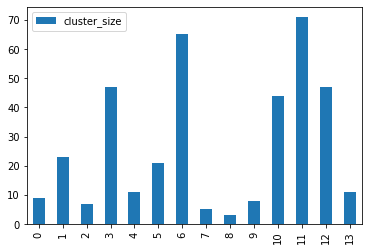

In [3]:
# Use the basic expectation for the number of clusters
n_clusters=ceil((len(exoplanet_data)/2)**0.5)
print(f'Number of clusters is {n_clusters}')
%time km = KMeans(n_clusters=n_clusters, random_state=10).fit(exoplanet_data[['Planet Temp. Est.','Star Temp. Eff.']])

print(f'Silhouette coefficient {metrics.silhouette_score(exoplanet_data, km.labels_, metric="euclidean")}')
print(f'Calinski Harabasz score {metrics.calinski_harabasz_score(exoplanet_data, km.labels_)}')

label_counts = dict(sorted(Counter(km.labels_).items()))
cluster_stats = pd.DataFrame(label_counts.values(), index=label_counts.keys(),columns=['cluster_size'])
print(cluster_stats.describe())
ax = cluster_stats.plot.bar()

In [4]:
# Clusters with one or two members aren't that useful
one_member = [x[0] for x in label_counts.items() if x[1]<3]
print(len(one_member))

0


In [5]:
cluster_assign = pd.DataFrame(km.labels_, columns= ['cluster'], index=exoplanet_data.index)
exoplanet_extract = pd.read_pickle('current_exo_ext')
exoplanet_extract['cluster']=np.nan

exoplanet_extract.iloc[exoplanet_data.index]
exoplanet_extract.loc[cluster_assign.index,'cluster']=cluster_assign['cluster']
exoplanet_extract.loc[exoplanet_data.index,'cluster']

0       10.0
1       12.0
3        3.0
18      10.0
19       3.0
        ... 
4142     6.0
4143    12.0
4146     6.0
4147    11.0
4160     5.0
Name: cluster, Length: 372, dtype: float64

In [6]:
exoplanet_extract.iloc[1988]

mpl_hostname      Kepler-418
mpl_letter                 b
mst_metratio           [M/H]
mpl_discmethod       Transit
mpl_pnum                   1
mpl_orbper                87
mpl_orbsmax              NaN
mpl_orbeccen             0.2
mpl_orbincl               90
mpl_massj                1.1
mpl_radj                 1.2
mpl_dens                 NaN
mpl_eqt                  NaN
mpl_insol                NaN
mst_teff             5.8e+03
mst_mass                0.98
mst_rad                  1.1
mst_age                    7
mst_lum                  NaN
mpl_status                 3
cluster                  NaN
Name: 1988, dtype: object

In [7]:
exoplanet_extract[exoplanet_extract['cluster']==8.0][['mpl_hostname','mpl_letter','mpl_orbper','mpl_orbsmax',
                                                    'mpl_massj','mpl_radj','mpl_dens','mpl_eqt','mst_teff',
                                                    'mst_mass','mst_rad','mst_age','cluster']].sort_values(['mpl_hostname','mpl_letter'])

,mpl_hostname,mpl_letter,mpl_orbper,mpl_orbsmax,mpl_massj,mpl_radj,mpl_dens,mpl_eqt,mst_teff,mst_mass,mst_rad,mst_age,cluster
513,Kepler-1654,b,1047.84,2.03,0.50,0.82,1.2,206.0,5597.0,1.01,1.18,5.0,8.0
3940,Kepler-1661,b,175.06,0.63,0.05,0.34,1.6,243.0,5100.0,0.84,0.76,2.0,8.0
1454,Kepler-22,b,289.86,0.85,0.11,0.21,14.7,262.0,5518.0,0.97,0.98,NaN,8.0


In [8]:
exoplanet_extract.to_pickle('km_clustered_exoplanets')

In [9]:
# Kepler-186f and Kepler-452b
exoplanet_extract[(exoplanet_extract['mpl_hostname'].str.match('Kepler-452')) & (exoplanet_extract['mpl_letter']=='b')]


,mpl_hostname,mpl_letter,mst_metratio,mpl_discmethod,mpl_pnum,mpl_orbper,mpl_orbsmax,mpl_orbeccen,mpl_orbincl,mpl_massj,...,mpl_dens,mpl_eqt,mpl_insol,mst_teff,mst_mass,mst_rad,mst_age,mst_lum,mpl_status,cluster
2328,Kepler-452,b,[Fe/H],Transit,1,384.84,1.05,NaN,89.81,NaN,...,NaN,265.0,1.1,5757.0,1.04,1.11,6.0,NaN,3,NaN


In [11]:
exoplanet_extract.groupby('cluster').agg({'mpl_eqt':['min','max'], 'mpl_dens':['min', 'max'], 
                         'mst_teff':['min','max'],'mpl_massj':['min','max']}).sort_values([('mpl_eqt','min'),('mpl_dens','min')])

mpl_eqt         mpl_dens        mst_teff          mpl_massj       
            min     max      min    max      min      max       min    max
cluster                                                                   
7.0       199.0   288.0     3.30   7.50   2559.0   3216.0  1.29e-03   0.02
8.0       206.0   262.0     1.20  14.70   5100.0   5597.0  5.35e-02   0.50
2.0       284.0   438.0     3.30   6.45   2559.0   3457.0  2.67e-03   0.03
13.0      347.0   478.0     0.03   7.00   4640.0   6018.0  1.30e-02   1.93
9.0       490.0   637.0     0.38  12.70   3270.0   4285.0  3.18e-03   0.97
4.0       497.0   676.0     0.03  14.00   5026.0   6302.0  7.00e-03   6.00
1.0       670.0  1000.0     0.19  31.93   3331.0   4975.0  8.24e-03   2.74
5.0       704.0   955.0     0.25  13.00   5070.0   6350.0  2.09e-02  20.10
10.0      963.0  1161.0     0.16  13.78   4309.0   6190.0  1.49e-02   7.25
3.0      1153.0  1418.0     0.08  33.10   4600.0   6327.0  1.20e-02   6.10
6.0      1322.0  1577.0     0.09  12.65   5165.0   6509.0  1.00e-02  10.39
11.0     1518.0  1836.0     0.11   6.39   5143.0   7175.0  1.10e-02   9.70
12.0     1838.0  2520.0     0.05   9.15   4550.0   7598.0  1.45e-02   7.60
0.0      2262.0  4050.0     0.27   6.64   6360.0  10170.0  1.47e+00  12.90